In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import NeuralNet as nn
import tensorflow as tf

def create_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]

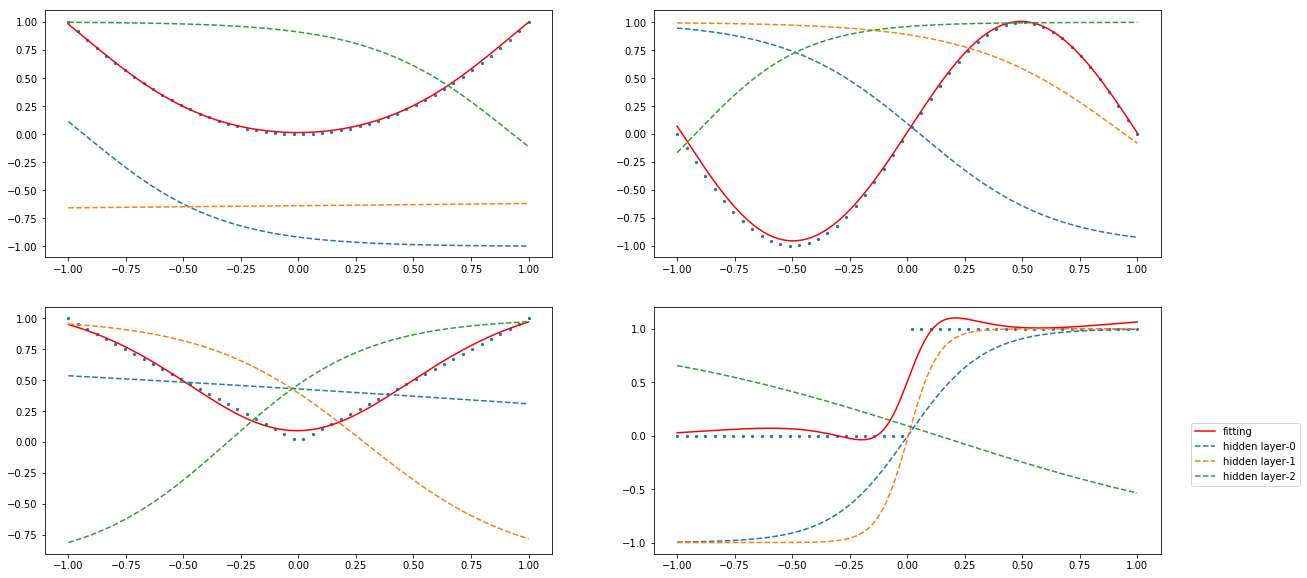

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

def neural_net(x):
    layer1 = tf.layers.dense(x, 3, activation=tf.nn.tanh)
    output = tf.layers.dense(layer1, 1, use_bias=True)
    return output, layer1

def model_fn(features, labels, mode):
    y, l1 = neural_net(features)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={'y':y, 'l1':l1})

    loss_op  = tf.nn.l2_loss(y - labels)
    train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss_op, global_step=tf.train.get_global_step())

    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss_op,
        train_op=train_op)
    return estim_specs

plt.figure(figsize=(20, 10))
for i, func in zip(range(1,5),func_list):
    plt.subplot(2, 2, i)
    x_train, y_train = create_data(func)

    model = tf.estimator.Estimator(model_fn)
    input_fn = tf.estimator.inputs.numpy_input_fn(x=x_train, y=y_train, num_epochs=None, shuffle=True)
    model.train(input_fn, steps=1000)

    x_test = np.linspace(-1, 1, 1000)
    input_fn = tf.estimator.inputs.numpy_input_fn(x=x_test[:,None], shuffle=False)
    output = list(model.predict(input_fn))
    y = np.asarray([item['y'] for item in output])[:,0]
    plt.scatter(x_train, y_train, s=5)
    plt.plot(x_test, y, color="r", label='fitting')
    for j in range(3):
        hidden = [item['l1'][j] for item in output]
        plt.plot(x_test, hidden, linestyle='dashed', label=r"hidden layer-{}".format(j))
plt.legend(bbox_to_anchor=(1.05, 0.55), loc=2, borderaxespad=0.5)
plt.show()

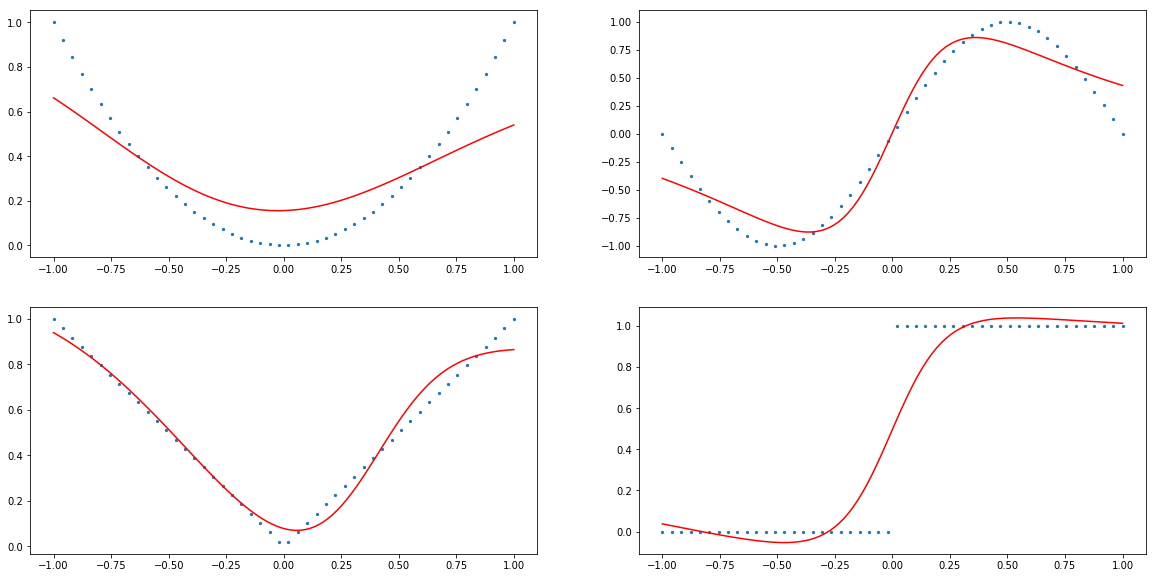

In [3]:
with tf.name_scope('placeholders'):
    x = tf.placeholder('float', [None, 1])
    y = tf.placeholder('float', [None, 1])

with tf.name_scope('neural_network'):
    layer1 = tf.contrib.layers.fully_connected(x, 3, activation_fn=tf.nn.tanh)
    output = tf.contrib.layers.fully_connected(layer1, 1, activation_fn=None)
    loss = tf.nn.l2_loss(output - y)

with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    plt.figure(figsize=(20, 10))
    for i, func in zip(range(1,5),func_list):
        plt.subplot(2, 2, i)
        x_train, y_train = create_data(func)

        # Train the network
        for i in range(100):
            sess.run([train_op, loss], feed_dict={x: x_train, y: y_train})
      
        x_test = np.linspace(-1, 1, 100)
        y_test = sess.run([output], feed_dict={x: x_test[:, None]})[0]
        plt.scatter(x_train, y_train, s=5, label='{}'.format(func.__name__))
        plt.plot(x_test, y_test, color="r", label='fitting')
    plt.show()

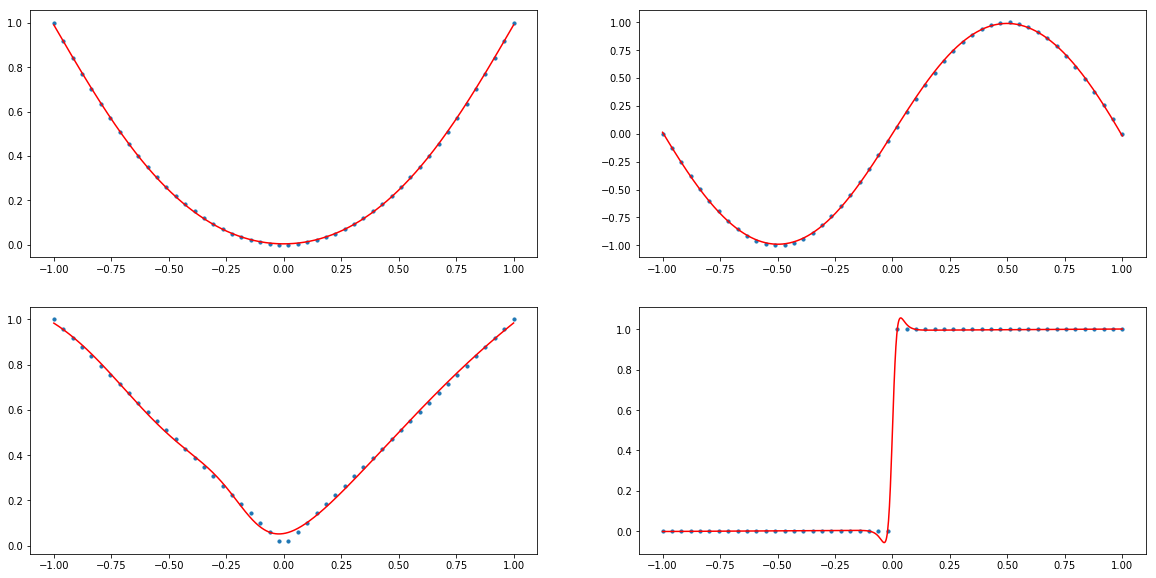

In [4]:
class RegressionNetwork(nn.Network):
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Gaussian(h @ self.w2 + self.b2, std=1., data=y)
        return self.py.mu.value

plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter, decay_step in zip(range(1, 5), func_list, [1000, 10000, 10000, 10000], [100, 100, 1000, 1000]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_data(func)
    model = RegressionNetwork(1, 3, 1)
    optimizer = nn.optimizer.Adam(model, 0.1)
    optimizer.set_decay(0.9, decay_step)
    for _ in range(n_iter): 
        model.clear()
        model(x_train, y_train)
        log_likelihood = model.log_pdf()
        log_likelihood.backward()
        optimizer.update()
    y = model(x)
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()